# CUNEF MUCD 2021/2022

## Autor: Jose Antonio Nazar

In [1]:
#Libraries
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import scikitplot as skplt
from sklearn.ensemble import RandomForestClassifier

import sklearn
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.ensemble import GradientBoostingClassifier 

from sklearn import metrics # Evaluación de modelo
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from dash import dcc
from dash import dash_table
from dash import html
import re

#matplotlib
import matplotlib
import matplotlib.pyplot as plt

import pickle
from aux_func import cargar_modelo

# Shap
import shap

# Dashboard
from explainerdashboard import ClassifierExplainer, ExplainerDashboard

import warnings
warnings.filterwarnings('ignore')

C:\Users\Jose\anaconda3\envs\aprendizaje\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm

The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`

The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`

The dash_table package is deprecated. Please replace
`import dash_table` with `from dash import dash_table`

Also, if you're using any of the table format helpers (e.g. Group), replace 
`from dash_table.Format import Group` with 
`from dash.dash_table.Format import Group`


In [3]:
#Read data
xtrain = pd.read_parquet("./datos/xtrain.parquet")
ytrain = pd.read_parquet("./datos/ytrain.parquet")
xtest = pd.read_parquet("./datos/xtest.parquet")
ytest = pd.read_parquet("./datos/ytest.parquet")

In [4]:
#Load preprocessor
preprocessor = cargar_modelo('./datos/preprocessor.pickle')

In [5]:
rf = Pipeline(steps=[
    ('preprocesador', preprocessor),
    ('clasificador', RandomForestClassifier())])

## Explicabilidad

In [6]:
# Load best model
with open('./datos/randomforest_optimizado.pickle', 'rb') as f:
    CV = pickle.load(f)
    
CV.best_params_

{'clasificador__class_weight': 'balanced',
 'clasificador__criterion': 'gini',
 'clasificador__max_depth': 8,
 'clasificador__max_features': 'log2',
 'clasificador__n_estimators': 500}

In [7]:
# predictions
ypred = CV.predict(xtest)
ypred_prob = CV.predict_proba(xtest)

## Curva de ganancia

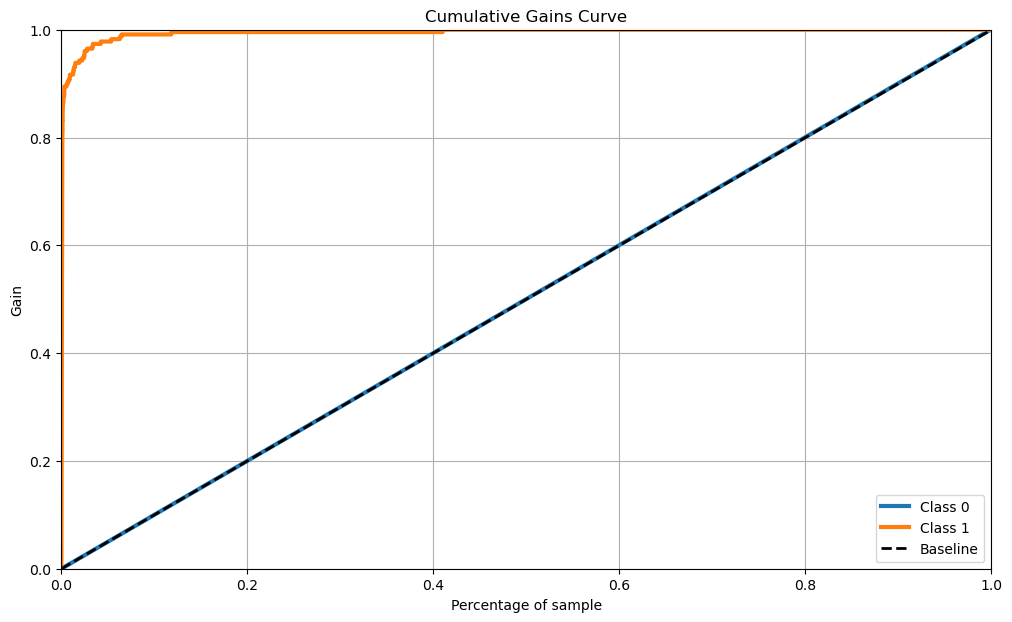

In [8]:
# Gain curve (curva de ganancia acumulada)
skplt.metrics.plot_cumulative_gain(ytest, ypred_prob, figsize=(12, 7));


## Curva ROC

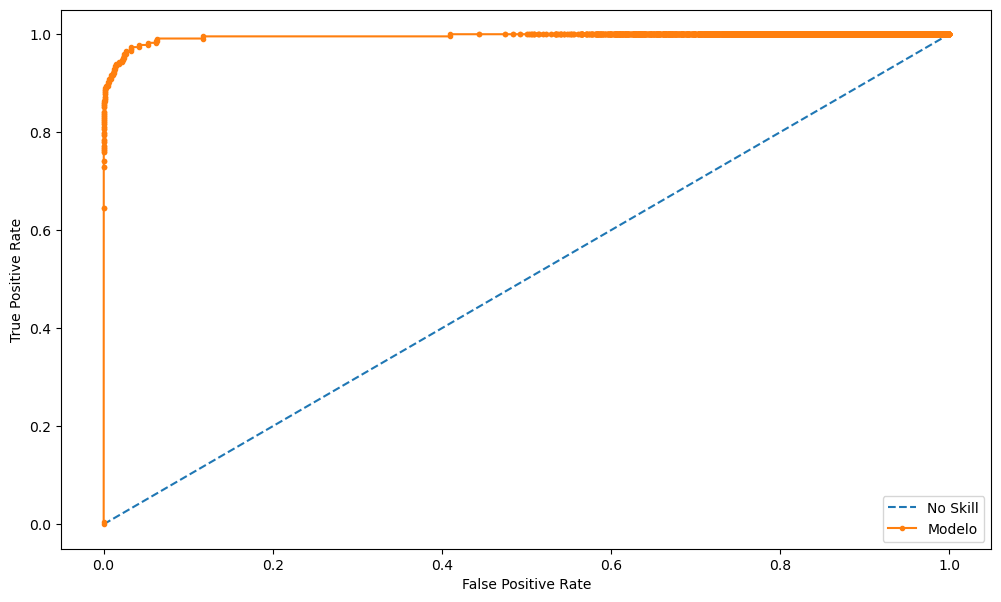

In [9]:
# keep probabilities for the positive outcome only
matplotlib.rcParams['figure.figsize'] = (12, 7)
yhat = ypred_prob[:, 1]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(ytest, yhat)
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label="Modelo")
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

## Curva lift

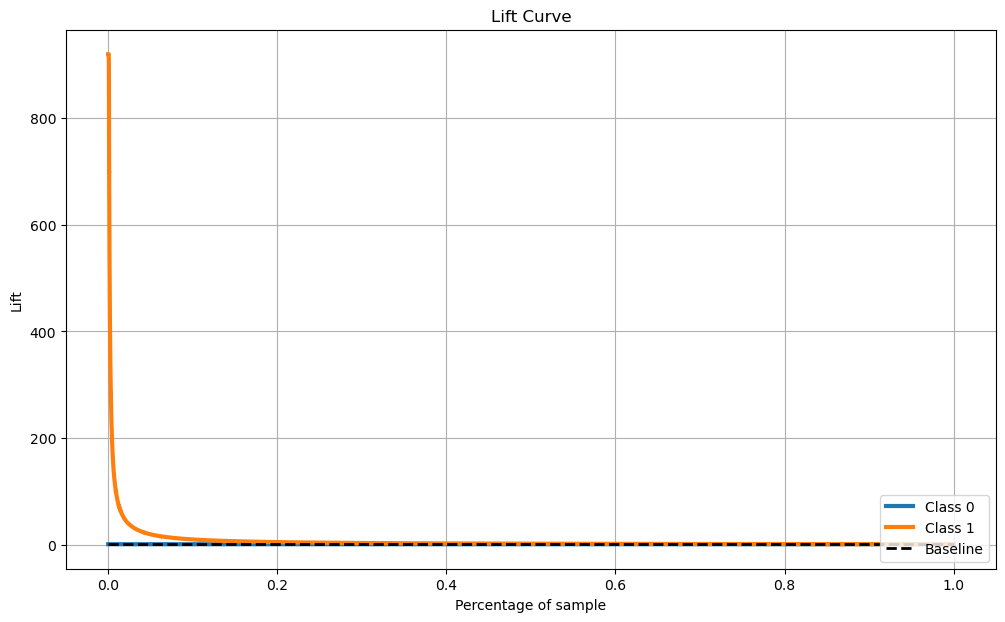

In [10]:
# lift curve
skplt.metrics.plot_lift_curve(ytest, ypred_prob, figsize=(12, 7));

## SHAP

In [17]:
#xtest
xtest = pd.DataFrame(CV.best_estimator_.named_steps['preprocesador'].transform(xtest))

In [18]:
# load JS visualization code to notebook
shap.initjs()

In [30]:
xtest.head()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,-1.086750,-0.279992,-0.866300,-0.293869,1.570136,-0.296892,0.231328,-0.175680,-0.333592,-0.365445,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,-0.574830,0.029372,0.093736,0.306353,-1.279138,0.351336,1.098902,1.217349,-0.333592,0.219393,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1.024922,1.042074,0.865147,-0.293869,-1.495539,-0.296892,1.079981,0.520835,-0.333592,0.780266,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,-1.278720,-0.587590,-0.784657,-0.287099,-1.459472,-0.291201,0.381998,1.217349,-0.333592,-0.426483,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1.024922,0.105346,1.349738,-0.290035,1.678337,-0.231121,1.651822,0.869092,-0.333592,0.091842,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [19]:
#create model
model = CV.best_estimator_.named_steps['clasificador']
explainer = shap.TreeExplainer(model)

In [20]:
#execute model
#shap_values = explainer.shap_values(xtest)

In [21]:
#with open('./datos/shap_values.pickle', 'wb') as f:
    #pickle.dump(shap_values, f)

In [22]:

# Para no tener que ejecutar
with open('./datos/shap_values.pickle', 'rb') as f:
    shap_values = pickle.load(f)

In [23]:
base_value = explainer.expected_value

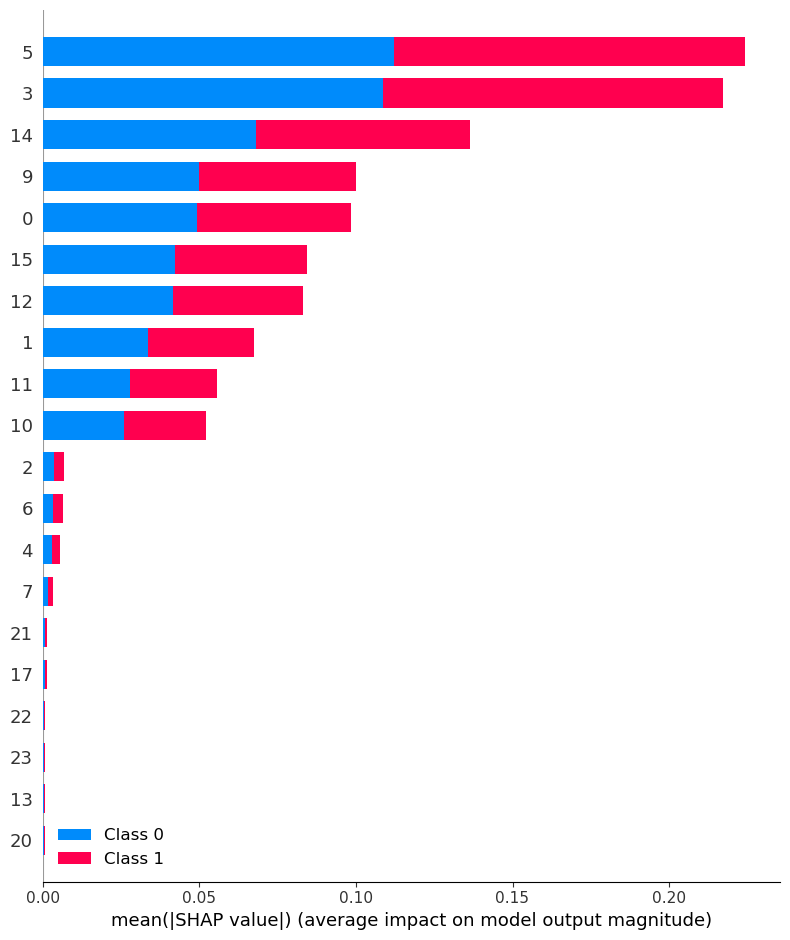

In [24]:
shap.summary_plot(shap_values, xtest)

In [28]:
# una sola linea, explicada
shap.force_plot(explainer.expected_value[0], shap_values[1][300], xtest.iloc[300,:])

In [29]:
shap.force_plot(explainer.expected_value[0], shap_values[1][100], xtest.iloc[100,:])

Estos gráficos nos muestran la importancia 'local' de nuestro modelo. Es decir, la importancia de una variable para un caso concreto. Es decir, en este caso nos indica porque se le ha considerado como fraude o no. La predicción se encuentra en 0.01.

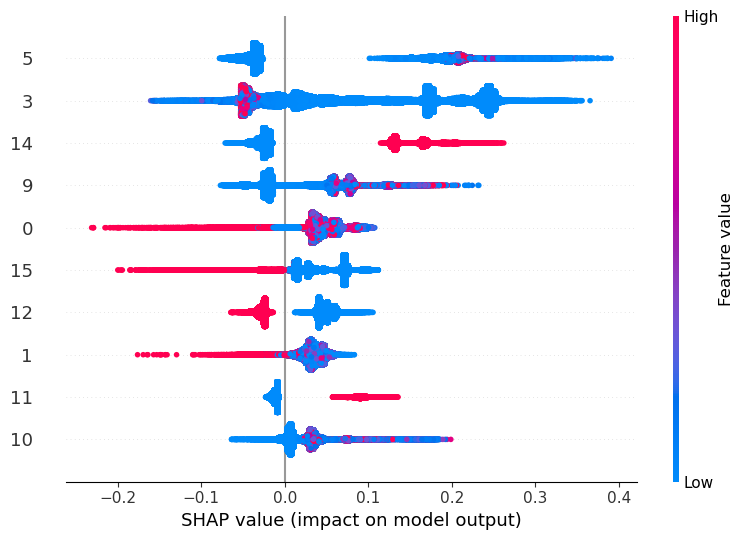

In [37]:
shap.summary_plot(shap_values[0], features=xtest, max_display=10)

El gráfico nos muestra la importancia de las variables para el modelo en general. De acuerdo con el gráfico vemos que las variables más relavantes son las que están en rojo. Por ejemplo la variable 14 es bastante relavante para nuestro modelo. 